In [4]:
import pandas as pd
from example.av_discretizer  import AVDiscretizer, Action, Position, Velocity, Rotation
from example.transition import TransitionRecorded
import matplotlib.pyplot as plt
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
from nuscenes import NuScenes


In [5]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')

#MINI
#nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

#FULL
#nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.493 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [ ]:
n#uscenes.render_sample('ebce5a3b3484446580028d6538e69a81')

The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

In [ ]:
import pandas as pd
from nuscenes import NuScenes
from nuscenes.prediction import convert_global_coords_to_local
from nuscenes.utils.geometry_utils import BoxVisibility
import argparse
import numpy as np
from pathlib import Path
import example.dataset.utils as utils

nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT, verbose=True)

def convert_coordinates(group: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the global coordinates of an object in each row to local displacement  relative to its previous position and orientation.

    This function iterates through a DataFrame where each row represents an object's state at a given time, including its position (x, y) and orientation (rotation).
    It computes the local displacement (delta_local_x, delta_local_y) at each timestep, using the position and orientation from the previous timestep as the reference frame.

    Args:
        group (DataFrame): A DataFrame containing the columns 'x', 'y' (global position coordinates), and 'rotation' (object's orientation as a quaternion).

    Returns:
        DataFrame: The input DataFrame with two new columns added ('delta_local_x' and 'delta_local_y') that represent the local displacement relative to the
                   previous position and orientation.

    Note:
        The first row of the output DataFrame will have 'delta_local_x' and 'delta_local_y'
        set to 0.0, as there is no previous state to compare.
    """

    #traslation = (group.iloc[0]['x'], group.iloc[0]['y'], 0) # Using the first row as the origin
    #rotation = group.iloc[0]['rotation']
    #coordinates = group[['x','y']].values
    #local_coords = convert_global_coords_to_local(coordinates, traslation, rotation)

    #group['local_x'], group['local_y'] = local_coords[:, 0], local_coords[:, 1]

    # Initialize the displacement columns for the first row
    group['delta_local_x'], group['delta_local_y'] = 0.0, 0.0

    for i in range(1, len(group)):
        # Use the previous row's position as the origin for translation
        translation = (group.iloc[i-1]['x'], group.iloc[i-1]['y'], 0)
        
        # Use the previous row's rotation; assuming constant rotation for simplicity
        rotation = group.iloc[i-1]['rotation']
        
        # Current row's global coordinates
        coordinates = group.iloc[i][['x', 'y']].values.reshape(1, -1)
        
        # Convert global coordinates to local based on the previous row's state
        local_coords = convert_global_coords_to_local(coordinates, translation, rotation)
        
        # Update the DataFrame with the computed local displacements
        group.at[group.index[i], 'delta_local_x'], group.at[group.index[i], 'delta_local_y'] = local_coords[0, 0], local_coords[0, 1]
    
    return group


def calculate_dynamics(group: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates velocity, acceleration, and heading change rate for each entry in a DataFrame,
    assuming the DataFrame is sorted by timestamp. The function adds three new columns to the
    DataFrame: 'velocity', 'acceleration', and 'heading_change_rate'.

    Args:
        group (DataFrame): A pandas DataFrame containing at least 'timestamp', 'x', 'y', and 'yaw'
                           columns. 'timestamp' should be in datetime format, and the DataFrame should
                           be sorted based on 'timestamp'.
    
    Returns:
        DataFrame: The input DataFrame with three new columns added: 'velocity', 'acceleration', and
                   'heading_change_rate', representing the calculated dynamics.
                   
    Note:
        This function handles cases where consecutive timestamps might be identical (time_diffs == 0)
        by avoiding division by zero and setting the respective dynamics values to NaN.
    """
    time_diffs = group['timestamp'].diff().dt.total_seconds()
    
    # Handle potential division by zero for velocity and acceleration calculations
    valid_time_diffs = time_diffs.replace(0, np.nan)
    
    # Calculate displacement (Euclidean distance between consecutive points)
    displacements = group[['x', 'y']].diff().pow(2).sum(axis=1).pow(0.5)
    
    # Meters / second.
    group['velocity'] = displacements / valid_time_diffs
    
    # Meters / second^2.
    group['acceleration'] = group['velocity'].diff() / valid_time_diffs
    
    # Radians / second.
    group['heading_change_rate'] = group['yaw'].diff() / valid_time_diffs

    return group

def front_cam_detection(samples:pd.DataFrame):
    """
    Given a sample in a scene, returns the objects in front of the vehicle, the action they are performing and the visibility (0=min, 4 =100%) from the ego-vehicle.
    
    NB:
    a sample of a scene (frame) has several sample annotations (Bounding Boxes). Each sample annotation has 0,1 or + attributes (pedestrian moving, etc). 
    the instance of an annotation is described in instance table, that tracks the n. of annotations in which the object appears
    
    for each sample, check, if there are, the n. of annotations. This can be retrieved in nusc.get('sample', first_sample_token)['anns'], which gives the list of annotations of the sample 
    for each annotation, check from which camera it is from

    """
    
    cam = 'CAM_FRONT'
    samples['detect_in_front'] = ""
    for sample_token in samples['sample_token']:
        detect_in_front= []
        sample = nuscenes.get('sample', sample_token)        
        if len(sample['anns'])>0: #checks if sample has annotated objects
            for ann_token in sample['anns']:
                _, boxes, _ = nuscenes.get_sample_data(sample['data'][cam], box_vis_level=BoxVisibility.ANY,
                                                                selected_anntokens=[ann_token])
                if len(boxes)>0: 
                    ann_info = nuscenes.get('sample_annotation', ann_token)
                    n_attributes = len(ann_info['attribute_tokens'])
                    if n_attributes>0: 
                        for attribute in ann_info['attribute_tokens']:
                            attribute_name = nuscenes.get('attribute', attribute)['name']
                            category = ann_info['category_name']
                            visibility = nuscenes.get('visibility', ann_info['visibility_token'])['token']
                            detect_in_front.append(
                                {'category': category,
                                'attribute': attribute_name, 
                                'visibility': visibility})
                                #print(f"annotation in {cam}: {nuscenes.get('attribute', attribute)['name']}") #attribute_tokens contains a list of tokens!!
                                #print(f"annotation category: {ann_info['category_name']}") #attribute_tokens contains a list of tokens!!
                                #print(f"visibility: {nuscenes.get('visibility', ann_info['visibility_token'])['token']}")
                                #nuscenes.render_annotation(ann_token)
                                #plt.show()
                                
        #print(f'for sample {sample_token} there are these {cam} annotations {detect_in_front}') 
        samples.loc[samples['sample_token'] == sample_token, 'detect_in_front'] = str(detect_in_front)
                                

    return samples



def process_scene_data(dataset: NuScenes, key_frame: bool, sensor: str) -> pd.DataFrame:
    """
    Processes agent data from the nuScenes dataset, creating a DataFrame with additional columns for velocity,
    acceleration, and heading change rate, based on sensor data filtering.

    Args:
        dataset (NuScenes): Instance of the NuScenes dataset.
        key_frame (bool): Flag indicating whether to filter for key frames only.
        sensor (str): Specific sensor modality to filter for. Use 'all' to include all sensors.

    Returns:
        pd.DataFrame: A DataFrame containing processed scene data with dynamics calculations.
    """

    sample = pd.DataFrame(dataset.sample)[['token', 'scene_token']].rename(columns={'token': 'sample_token'})
    
    # add front camera objects information
    sample = front_cam_detection(sample)


    
    sample_data = pd.DataFrame(dataset.sample_data).query(f"is_key_frame == {key_frame}")[['sample_token', 'ego_pose_token','calibrated_sensor_token']]
    ego_pose = pd.DataFrame(dataset.ego_pose).rename(columns={'token': 'ego_pose_token'})
    ego_pose[['x', 'y', 'z']] = pd.DataFrame(ego_pose['translation'].tolist(), index=ego_pose.index)
    
    merged_df = sample.merge(sample_data, on='sample_token').merge(ego_pose, on='ego_pose_token').drop(columns=['ego_pose_token', 'sample_token', 'translation'])

    if sensor != 'all':
        calibrated_sensors = pd.DataFrame(dataset.calibrated_sensor).rename(columns={'token': 'calibrated_sensor_token'})
        sensors = pd.DataFrame(dataset.sensor).rename(columns={'token': 'sensor_token'})
        sensors = sensors[sensors['modality'] == sensor].merge(calibrated_sensors, on='sensor_token').drop(columns=['rotation','translation', 'channel','camera_intrinsic', 'sensor_token'])
        merged_df = sensors.merge(merged_df, on='calibrated_sensor_token' ).drop(columns=['calibrated_sensor_token'])
        
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], unit='us')

    merged_df['yaw'] = merged_df['rotation'].apply(utils.quaternion_yaw)

    merged_df.sort_values(by=['scene_token', 'timestamp'], inplace=True)
    
    # Group by 'scene_token' and calculate dynamics
    final_df = merged_df.groupby('scene_token', as_index=False).apply(calculate_dynamics).dropna()

    # Compute  for each scene, the movement of the agent in local x and y
    df_updated = pd.concat([convert_coordinates(group) for _, group in final_df.groupby('scene_token')])

    # mark destination state
    df_updated['is_destination'] = False
    for scene_token in df_updated['scene_token'].unique():
        last_index = df_updated[df_updated['scene_token'] == scene_token].index[-1]
        df_updated.at[last_index, 'is_destination'] = True

    return df_updated


states = process_scene_data(nuscenes, True, 'lidar')

states.head()


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.556 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
for sample ca9a282c9e77460f8360f564131a8af5 there are these CAM_FRONT annotations [{'category': 'human.pedestrian.adult', 'attribute': 'pedestrian.standing', 'visibility': '1'}, {'category': 'human.pedestrian.adult', 'attribute': 'pedestrian.moving', 'visibility': '2'}, {'category': 'vehicle.car', 'attribute': 'vehicle.stopped', 'visibility': '3'}, {'category': 'vehicle.bicycle', 'attribute': 'cycle.with_rider', 'visibility': '1'}, {'category': 'human.pedestrian.adult', 'attribute': 'pedestrian.moving', 'visibility': '2'}, {'category': 'human.pedestrian.adult', 'attribute': 'pedestrian.moving', 'visibility': '4'}, {'category': 'vehicle.car', 'attribute': 'vehicle.movin

InvalidIndexError: You can only assign a scalar value not a <class 'str'>

Load the CSV data into a DataFrame


In [ ]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'
}
df = pd.read_csv(DATAROOT / 'all_sensors_data.csv', dtype=dtype_dict, parse_dates=['timestamp'])

df.head()

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y,is_destination
0,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.301132,"[-0.1557237496690409, 0.011222825001502285, 0....",329.647494,660.196689,0.0,2.828707,5.108550,-0.034804,-0.045330,0.000000,0.000000,False
1,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.801064,"[-0.16117694469754024, 0.009157178788916257, 0...",327.233834,661.025514,0.0,2.817706,5.104695,-0.007711,-0.022006,0.045648,2.551592,False
2,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.200261,"[-0.16222999791894513, 0.010261981974878865, -...",325.362312,661.686833,0.0,2.815673,4.972301,-0.331650,-0.005091,0.031316,1.984681,False
3,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.651414,"[-0.16605361559690043, 0.007585584174464603, -...",323.362925,662.405363,0.0,2.807968,4.709219,-0.583132,-0.017080,0.040541,2.124192,False
4,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:11.149672,"[-0.1790782272855317, 0.009448521999393368, -0...",321.358449,663.164911,0.0,2.781689,4.302103,-0.817080,-0.052741,0.061262,2.142681,False


## Trajectory of AV in a Scene

Let's do an example of computing trajectory of a vehicle in a scene. We then check if the rendering of the scene match the computed trajectory.

In [ ]:
# initialize discretizer
av_discretizer = AVDiscretizer()


List of scenes

In [ ]:
df['scene_token'].unique()

array(['2fc3753772e241f2ab2cd16a784cc680',
       '325cef682f064c55a255f2625c533b75',
       '6f83169d067343658251f72e1dd17dbc',
       'bebf5f5b2a674631ab5c88fd1aa9e87a',
       'c5224b9b454b4ded9b5d2d2634bbda8a',
       'cc8c0bf57f984915a77078b10eb33198',
       'd25718445d89453381c659b9c8734939',
       'de7d80a1f5fb4c3e82ce8a4f213b450a',
       'e233467e827140efa4b42d2b4c435855',
       'fcbccedd61424f1b85dcbf8f897f9754'], dtype=object)

Select a scene and test the  algorithm


In [ ]:
scene_test = df['scene_token'].unique()[1]
example_scene_df = df[df['scene_token']==scene_test]
example_scene_df

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y,is_destination
39,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:14.547551,"[0.6782718418961043, 0.006612868107668059, -0....",716.057003,1805.982806,0.0,-1.650690,4.128817,0.133117,-0.349081,0.000000,0.000000,False
40,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:14.947904,"[0.6258213669434368, 0.013159286965631187, -0....",715.808654,1804.381613,0.0,-1.788886,4.047275,-0.203675,-0.345184,0.119768,1.615906,False
41,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:15.447825,"[0.5652863364844423, 0.0029788684425571576, -0...",715.207762,1802.441890,0.0,-1.940013,4.061970,0.029393,-0.302302,0.166970,2.023788,False
42,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:15.947081,"[0.5114887252932175, 0.0022321108037849802, 0....",714.309547,1800.527887,0.0,-2.067765,4.234870,0.346316,-0.255885,0.146950,2.109171,False
43,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:16.446970,"[0.47219377566662446, -0.0006707801460216395, ...",713.182494,1798.653601,0.0,-2.158036,4.375075,0.280473,-0.180582,0.097125,2.184894,False
44,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:16.946289,"[0.451220044620286, 0.0015131331966651163, 0.0...",711.871389,1796.791023,0.0,-2.205332,4.561736,0.373830,-0.094720,0.059471,2.276985,False
45,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:17.446737,"[0.4388360312827414, 0.007251556779002451, 0.0...",710.436917,1794.899783,0.0,-2.232960,4.743168,0.362539,-0.055207,0.034114,2.373464,False
46,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:17.947155,"[0.4271269246008053, 0.010518371240250532, 0.0...",708.965479,1793.068496,0.0,-2.258890,4.694477,-0.097299,-0.051816,0.034549,2.348947,False
47,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:18.447571,"[0.41284620363879587, 0.011700167120465284, 0....",707.448144,1791.300524,0.0,-2.290303,4.655754,-0.077383,-0.062775,0.049300,2.329292,False
48,lidar,325cef682f064c55a255f2625c533b75,2018-10-08 07:37:18.948012,"[0.390783157267678, 0.01835125563680318, 0.003...",705.871116,1789.599718,0.0,-2.338347,4.634773,-0.041925,-0.096002,0.065276,2.318512,False


Compute the trajectoy of the scene

In [ ]:
recorder = TransitionRecorded()
trajectory = av_discretizer.compute_trajectory(example_scene_df)
#recorder.process_and_save_transitions(trajectory, av_discretizer.unique_states)
recorder.process_transitions(trajectory)
#recorder.save_to_csv(av_discretizer.unique_states)

State 0: [0.0, 0.0, 4.128817120799394, -0.3490810992162783, 0.1331168895185845]
Discretized state: 0 (Position(179,451), Velocity(LOW), Rotation(SLIGHT_LEFT))
Action: Action.BRAKE_TURN_RIGHT

State 1: [0.1197679693119718, 1.61590642052018, 4.047275356307623, -0.3451844304723347, -0.203674668334624]
Discretized state: 1 (Position(178,451), Velocity(LOW), Rotation(SLIGHT_LEFT))
Action: Action.TURN_RIGHT

State 2: [0.1669703442916177, 2.0237877436482266, 4.061969617028694, -0.3023021896147296, 0.0293931655623025]
Discretized state: 2 (Position(178,450), Velocity(LOW), Rotation(SLIGHT_LEFT))
Action: Action.GAS_TURN_RIGHT

State 3: [0.1469495138135126, 2.1091712639062385, 4.234869839841759, -0.2558850845793648, 0.34631576348219]
Discretized state: 3 (Position(178,450), Velocity(LOW), Rotation(SLIGHT_LEFT))
Action: Action.GAS

State 4: [0.0971245910286168, 2.184894280645941, 4.375075153782305, -0.1805818295058055, 0.2804728928633084]
Discretized state: 4 (Position(178,449), Velocity(LOW), Ro

Plot trend of state in time for each instance of a scene.

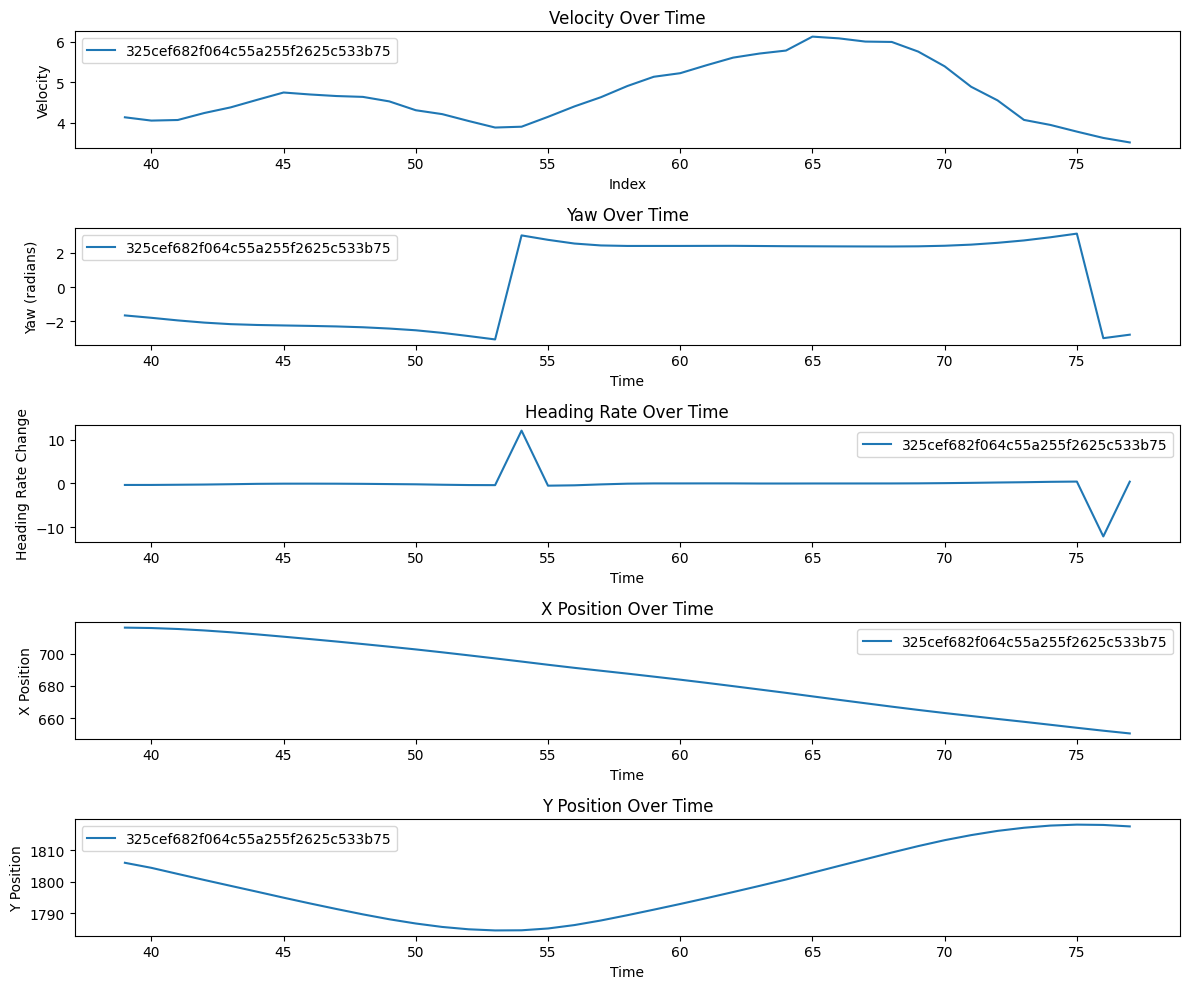

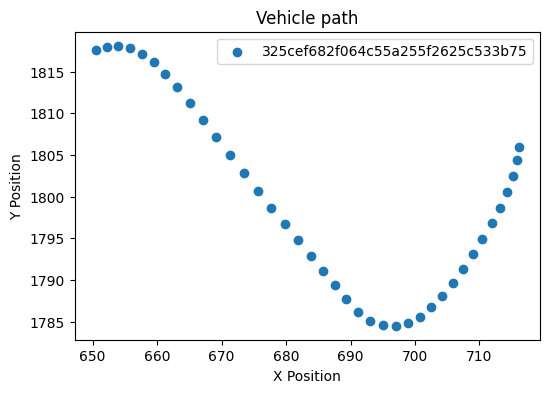

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['velocity'], label=scene_token)
plt.title('Velocity Over Time')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(5, 1, 2)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['yaw'], label=scene_token)
plt.title('Yaw Over Time')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()

plt.subplot(5, 1, 3)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['heading_change_rate'], label=scene_token)
plt.title('Heading Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heading Rate Change')
plt.legend()

plt.subplot(5, 1, 4)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['x'], label=scene_token)
plt.title('X Position Over Time')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.legend()

plt.subplot(5, 1, 5)  # Moved inside the same plt.figure block
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['y'], label=scene_token)
plt.title('Y Position Over Time')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()


# Plot x vs y positions for each instance
plt.figure(figsize=(6, 4))
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.scatter(group['x'], group['y'], label=scene_token)
plt.title('Vehicle path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

To render the scene (video):

In [ ]:
#nuscenes.render_scene(scene_test)

## All scenes trajectory information


Now, apply the above to all scenes in the dataset.

In [ ]:
av_discretizer = AVDiscretizer()
trajectory = av_discretizer.compute_trajectory(df)

State 0: [0.0, 0.0, 5.108549775006556, -0.0453298240761698, -0.0348037318593867]
Discretized state: 0 (Position(82,165), Velocity(LOW), Rotation(RIGHT))
Action: Action.STRAIGHT

State 1: [0.0456478454936385, 2.5515920468546924, 5.10469490440442, -0.0220058832146411, -0.007710789871694]
Discretized state: 1 (Position(81,165), Velocity(LOW), Rotation(RIGHT))
Action: Action.BRAKE

State 2: [0.0313156638906143, 1.9846806565211763, 4.972301147669266, -0.0050912652853189, -0.3316501795733787]
Discretized state: 2 (Position(81,165), Velocity(LOW), Rotation(RIGHT))
Action: Action.BRAKE

State 3: [0.0405408994690575, 2.1241916563087795, 4.709219465049271, -0.0170801794347065, -0.5831318479983395]
Discretized state: 3 (Position(80,165), Velocity(LOW), Rotation(RIGHT))
Action: Action.BRAKE

State 4: [0.0612618323316302, 2.142681440792965, 4.302102598495416, -0.0527406448615074, -0.8170804413654266]
Discretized state: 4 (Position(80,165), Velocity(LOW), Rotation(RIGHT))
Action: Action.BRAKE

State

In [ ]:
transition = TransitionRecorded()
transition.process_transitions(trajectory)
transition.save_to_csv(av_discretizer.unique_states, path=str(DATAROOT))

# Policy Graph Generation

In [ ]:
env = SelfDrivingEnvironment()
av_discretizer = AVDiscretizer()
pg = PG.PolicyGraph.from_nodes_and_edges(str(DATAROOT / 'nuscenes_nodes.csv'), str(DATAROOT / 'nuscenes_edges.csv'), env, av_discretizer  )

In [ ]:
print(f'Number of nodes: {len(pg.nodes)}')
print(f'Number of edges: {len(pg.edges)}')

Number of nodes: 229
Number of edges: 276


In [ ]:
arbitrary_state = list(pg.nodes)[10]

print(arbitrary_state)
print(f'  Times visited: {pg.nodes[arbitrary_state]["frequency"]}')
print(f'  p(s):          {pg.nodes[arbitrary_state]["probability"]:.3f}')

(Position(178,451), Velocity(LOW), Rotation(SLIGHT_LEFT))
  Times visited: 1
  p(s):          0.003


In [ ]:
arbitrary_edge = list(pg.edges)[66]

print(f'From:    {arbitrary_edge[0]}')
print(f'Action:  {arbitrary_edge[2]}')
print(f'To:      {arbitrary_edge[1]}')
print(f'  Times visited:      {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["frequency"]}')
print(f'  p(s_to,a | s_from): {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["probability"]:.3f}')

From:    (Position(456,216), Velocity(MEDIUM), Rotation(FORWARD))
Action:  5
To:      (Position(457,216), Velocity(MEDIUM), Rotation(FORWARD))
  Times visited:      1
  p(s_to,a | s_from): 1.000


### Using PG-based policies

In [ ]:
from pgeon import PGBasedPolicy, PGBasedPolicyMode, PGBasedPolicyNodeNotFoundMode
from random import sample
from pgeon import Predicate


In [ ]:
policy_mode = PGBasedPolicyMode.STOCHASTIC
node_not_found_mode = PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES

policy = PGBasedPolicy(pg, policy_mode,node_not_found_mode )
pg._normalize()
print(f'Policy Graph with {policy_mode} and {node_not_found_mode}')
print(f'PG number of nodes: {len(policy.pg.nodes)}')
print(f'PG number of edges: {len(policy.pg.edges)}')
        
        
arbitrary_state = [1484, 1180, 5, 3]#sample(policy.pg.nodes,1)[0]
discretized_obs = policy.pg.discretizer.discretize(arbitrary_state)
str_obs = av_discretizer.state_to_str(discretized_obs)
str_to_state = av_discretizer.str_to_state(str_obs)
action = policy.act(arbitrary_state)

        
print(f'Observed state:  {arbitrary_state}')
print(f'Discretization:  {discretized_obs}')
#print(f'time visited: {policy.pg.nodes[discretized_obs]["frequency"]}')
print(f'Selected action: {action}')



Policy Graph with PGBasedPolicyMode.STOCHASTIC and PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES
PG number of nodes: 229
PG number of edges: 276
[1484, 1180, 5, 3]


ValueError: too many values to unpack (expected 3)

Question 1

In [ ]:
possible_actions = pg.question1(discretized_obs, verbose=True)

I will take one of these actions:
	-> STRAIGHT 	Prob: 66.67 %
	-> BRAKE_TURN_LEFT 	Prob: 33.33 %


Question 2

In [ ]:
action_id = AVDiscretizer.get_action_id(Action.IDLE)
best_states = pg.question2(action_id, verbose=True)
                

*********************************
* When do you perform action 1?
*********************************
Most probable in 243 states:
	-> (Position(391,210), Velocity(STOPPED), Rotation(LEFT))
	-> (Position(194,625), Velocity(STOPPED), Rotation(SLIGHT_LEFT))
	-> (Position(384,330), Velocity(STOPPED), Rotation(FORWARD))
	-> (Position(299,281), Velocity(STOPPED), Rotation(RIGHT))
	-> (Position(156,493), Velocity(STOPPED), Rotation(RIGHT))
	-> (Position(530,222), Velocity(STOPPED), Rotation(LEFT))
	-> (Position(195,231), Velocity(STOPPED), Rotation(LEFT))
	-> (Position(145,442), Velocity(STOPPED), Rotation(LEFT))
	-> (Position(132,424), Velocity(STOPPED), Rotation(SLIGHT_LEFT))
	-> (Position(189,379), Velocity(STOPPED), Rotation(FORWARD))
	-> (Position(200,345), Velocity(STOPPED), Rotation(RIGHT))
	-> (Position(83,243), Velocity(STOPPED), Rotation(RIGHT))
	-> (Position(105,206), Velocity(STOPPED), Rotation(FORWARD))
	-> (Position(192,105), Velocity(STOPPED), Rotation(RIGHT))
	-> (Position(364,

In [ ]:
policy_modes = [PGBasedPolicyMode.STOCHASTIC, PGBasedPolicyMode.GREEDY]
node_not_found_modes = [PGBasedPolicyNodeNotFoundMode.RANDOM_UNIFORM, PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES]
action_id = AVDiscretizer.get_action_id(Action.GAS)


for policy_mode in policy_modes:
    for node_not_found_mode in node_not_found_modes:
        policy = PGBasedPolicy(pg, mode=policy_mode,  node_not_found_mode=node_not_found_mode)
        greedy = True if policy_mode is PGBasedPolicyMode.GREEDY else False
        print(f'Policy Graph with {policy_mode} and {node_not_found_mode}')
        print()
        print(f'Supposing I was in 107,405, stopped and heading right, '
            f'if I did not choose to gas and go straight was due to...')
        policy.pg._normalize() #do i need to normalize before this step?
        counterfactuals = policy.pg.question3((
            Predicate(Position, [177, 449]),
            Predicate(Velocity, [Velocity(Velocity.LOW)]),
            Predicate(Rotation, [Rotation(Rotation.LEFT)])), action_id, greedy, verbose=True)
        
        print()

Policy Graph with PGBasedPolicyMode.STOCHASTIC and PGBasedPolicyNodeNotFoundMode.RANDOM_UNIFORM

Supposing I was in 107,405, stopped and heading right, if I did not choose to gas and go straight was due to...
***********************************************
* Why did not you perform X action in Y state?
***********************************************
[(4, 0.5), (7, 0.5)]
I would have chosen: 7
I would have chosen 4 under the following conditions:
	I don't know where I would have ended up

Policy Graph with PGBasedPolicyMode.STOCHASTIC and PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES

Supposing I was in 107,405, stopped and heading right, if I did not choose to gas and go straight was due to...
***********************************************
* Why did not you perform X action in Y state?
***********************************************
[(4, 0.5), (7, 0.5)]
I would have chosen: 4
I would have chosen 4 under the following conditions:
	I don't know where I would have ended up

Policy Gra

# Policy Graph Evaluation and Comparison

## Compute Static Metrics


In [ ]:
from example.nuscenes.evaluator import PolicyGraphEvaluator
evaluator = PolicyGraphEvaluator(pg)
entropy_metrics_graph = evaluator.compute_entropy_metrics()

for state, metrics in entropy_metrics_graph.items():
    print(f"State: {state}, H(s): {metrics['Hs']:.2f}, Ha(s): {metrics['Ha']:.2f}, Hw(s): {metrics['Hw']:.2f}")

ModuleNotFoundError: No module named 'example.nuscenes'

Ideal situation: knowing the current state unqeuivocally determines the following action and state. To evaluate this we use Entropy.

Entropy Interpretation: level of uncertainty of a variable (check PG_position_paper).

- H_a(s): 0 --> state s perfectly determines the following action a.
Too simple graphs with few nodes show larger action uncertainty, making output less reliable.

- H_w(s): 0 --> state s perfectly determines the following state s'.

- H(s): 0 --> state s perfectly determines the following pais of s', a.

## Improve Policy

In [ ]:
#path_pg_data = Path('/home/saramontese/Desktop/MasterThesis')

#sub_pg = PG.PolicyGraph.from_nodes_and_edges(str(path_pg_data / 'nuscenes_nodes.csv'), str(path_pg_data / 'nuscenes_edges.csv'), env, av_discretizer  )

In [ ]:
#initial_state = example_scene_df.iloc[0][['x', "y", "velocity", "yaw"]].values
#final_state = example_scene_df.iloc[-1][['x', "y", "velocity", "yaw"]].values
#print('initial scene state: ', initial_state)
#print('final scene state: ', final_state)

initial scene state:  [716.0570033520877 1805.9828064891144 4.128817120799394
 -1.6506901524698323]
final scene state:  [650.486841739074 1817.543033825678 3.50612559917745 -2.7694845423521763]


In [ ]:
#sub_agent = PGBasedPolicy(sub_pg, mode=PGBasedPolicyMode.GREEDY)
#reward = env.compute_total_reward(sub_agent, initial_state, final_state, max_steps=100)
#print('scene reward before improvement: ', reward)

In [ ]:
#reward = env.compute_total_reward(pg)
#print('Total PG reward before improvement: ', reward)

Total PG reward before improvement:  None


In [ ]:
#pg.policy_iteration(sub_pg)
#print('scene reward after improvement: ', env.compute_total_reward(pg))


## Compute Rewards

1. I consider the total pg.
2. I consider each scene as episode, with a initial state and end state
3. For each scene, i compute the reward of the PG.
4. I compute the avg scene reward.

I do this for all the possible pgBased policies.

in which format the scenes?
can i create a function that creates a pg from a dataframe without having to store it the dataframe as csv and then load it?

In [ ]:
#for each scenes:
    #initial_state = example_scene_df.iloc[0][['x', "y", "velocity", "yaw"]].values
    #final_state = example_scene_df.iloc[-1][['x', "y", "velocity", "yaw"]].values
    #print('initial scene state: ', initial_state)
    #print('final scene state: ', final_state)